## IMAGE COMPRESSION AND CLASSIFICATION USING QUBITS AND QUANTUM DEEP LEARNING

本篇文章基于FRQI编码方法提出了一种新的编码方式，并应用于图像的二分类中。复现内容主要包含如下：
1. 数据的预处理
2. 编码线路的实现
3. 网络结构
4. 训练模型
5. 结果展示

### 1. 数据的预处理
文中使用MNIST中的3和6，下采样到8x8和16x16两种分辨率，最后二值化。最终剩下大约12000个训练样本，2000个测试样本（论文中是1100个测试样本）。

In [1]:
# 1.1 加载MNIST数据
import numpy as np
np.random.seed(22)
import matplotlib.pyplot as plt
from src.data import load_mnist, extract_3and6, resize_image_batch
x_train_path='./mnist/train-images-idx3-ubyte.gz'
y_train_path='./mnist/train-labels-idx1-ubyte.gz'
x_test_path='./mnist/t10k-images-idx3-ubyte.gz'
y_test_path='./mnist/t10k-labels-idx1-ubyte.gz'
(x_train, y_train), (x_test, y_test)=load_mnist(x_train_path, y_train_path, 
                                                x_test_path, y_test_path, 
                                                normalize=True, one_hot=False)
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(60000, 784) (10000, 784)
(60000,) (10000,)


In [2]:
# 1.2 提取3 和 6, 3 的标签为1, 6的标签为 -1
(x_train, y_train), (x_test, y_test) = extract_3and6(x_train, y_train, x_test, y_test)
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(12049, 784) (1968, 784)
(12049,) (1968,)


8x8 resolution: (12049, 64) (1968, 64)
16x16 resolution: (12049, 256) (1968, 256)


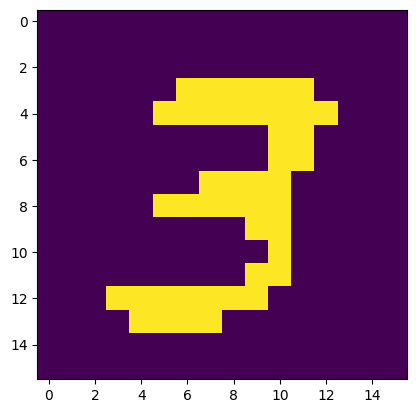

In [3]:
# 1.3 下采样, 二值化
x_train8 = resize_image_batch(x_train, 8)
x_train16 = resize_image_batch(x_train, 16)
x_test8 = resize_image_batch(x_test, 8)
x_test16 = resize_image_batch(x_test, 16)

x_train8 = np.where(x_train8 > 0.5, 1., 0).astype(np.float32)
x_train16 = np.where(x_train16 > 0.5, 1., 0).astype(np.float32)
x_test8 = np.where(x_test8 > 0.5, 1., 0).astype(np.float32)
x_test16 = np.where(x_test16 > 0.5, 1., 0).astype(np.float32)

print("8x8 resolution:", x_train8.shape, x_test8.shape)
print("16x16 resolution:", x_train16.shape, x_test16.shape)
plt.imshow(x_train16[0].reshape(16, 16))

### 2. 编码线路的实现

文中使用了两种编码方式，第一种是FRQI，第二种是由FQRI改进的压缩方式。
1. FRQI使用前n个qubits编码位置，最后一个编码颜色。
2. 在FRQI的基础上，把最后两个qubits压缩到编码颜色的qubit上。

In [4]:
# 2.1 FRQI
from src.qnn import frqi_encoder
encoder1 = frqi_encoder(8, False)
encoder1.svg()

In [5]:
from mindquantum import Simulator
sim = Simulator(backend='mqvector', n_qubits=3+2)
sim.apply_circuit(encoder1, [1, 0, 1, 0, 1, 1, 1, 1])
sim.get_qs(True)

'√2/4¦00100⟩\n√2/4¦00110⟩\n√2/4¦01000⟩\n√2/4¦01001⟩\n√2/4¦01010⟩\n√2/4¦01011⟩\n√2/4¦01101⟩\n√2/4¦01111⟩'

In [6]:
# 2.2 基于FRQI的压缩线路，把后两位压缩到颜色qubit中。
# 化简之后，每四个pixels一组，生成一个color qubit的旋转角度。
# 需要经典把数据预处理，最后计算一个总的旋转角度
from src.data import frqi_data_compression
x_train8_compressed = frqi_data_compression(x_train8)
x_train16_compressed = frqi_data_compression(x_train16)
x_test8_compressed = frqi_data_compression(x_test8)
x_test16_compressed = frqi_data_compression(x_test16)

### 3. 网络结构

文中给出了两种量子神经网络结构，并实现了一个简单的经典网络进行对比：

1. Color-Readout-Alternating-Double-Layer (CRADL)
2. Color-Readout-Alternating-Mixed-Layer (CRAML)
3. 经典ANN, 结构：64-1-1，256-1-1

In [7]:
# 3.1 CRADL
from src.qnn import CRADL
ansatz = CRADL(2, 2)
ansatz.svg()

In [8]:
# 3.2 CRAML
from src.qnn import CRAML
ansatz = CRAML(2, 2)
ansatz.svg()

### 4. 训练模型
论文中共做了五组实验，分别是：
1. qnn1, 8x8, 6 qubits no compression, 72 params 12 层
2. qnn2, 8x8, 4 qubits with compression, 64 params 16 层 
3. 8x8, classical 64-1-1 with bias 67 params(如果按照论文使用65个参数，没有bias分类结果很差)

4. 16x16, 6 qubits with compression, 252 params 42 层
5. 16x16, classical 256-1-1 with bias 259 params(同上，原文为257个参数)

训练过程在train.py中，采用了"mqvector"加速。

1. 作图的数据被存储在"validation.npy"中, 此时使用的hinge loss
2. 作图的数据被存储在"validation_mse.npy"中, 此时使用的mse loss

In [9]:
from src.data import create_dataset
from train import train
from src.qnn import QNN
from src.nn import Network

In [10]:
train8 = create_dataset(zip(x_train8, y_train))
test8 = create_dataset(zip(x_test8, y_test))
train8_compressed = create_dataset(zip(x_train8_compressed, y_train))
test8_compressed = create_dataset(zip(x_test8_compressed, y_test))

qnn = QNN(8, True, 16)
print(qnn)
# result = train(qnn, train8_compressed, test8_compressed)
# print(result)

QNN<
  (qnn): MQLayer<
    (evolution): MQOps<6 qubits mqvector VQA Operator>
    >
  >


### 5. 结果展示

复现论文中Figure 6, 图中展示了10折交叉验证在测试集上的准确率及其标准差。本次复现实现了两种loss的结果。

1. 使用hinge loss时，和论文相似度较差。
2. 使用mse loss时，和论文结果相似度更高。

In [11]:
# 5.1 hinge loss 结果展示
validation_dict = np.load('validation.npy', allow_pickle=True).item()
qnn1_mean = np.average(validation_dict['qnn1'], axis=0) * 100
qnn1_std = np.std(validation_dict['qnn1'], axis=0) * 100
qnn2_mean = np.average(validation_dict['qnn2'], axis=0) * 100
qnn2_std = np.std(validation_dict['qnn2'], axis=0) * 100
qnn3_mean = np.average(validation_dict['qnn3'], axis=0) * 100
qnn3_std = np.std(validation_dict['qnn3'], axis=0) * 100
cnn1_mean = np.average(validation_dict['cnn1'], axis=0) * 100
cnn1_std = np.std(validation_dict['cnn1'], axis=0) * 100
cnn2_mean = np.average(validation_dict['cnn2'], axis=0) * 100
cnn2_std = np.std(validation_dict['cnn2'], axis=0) * 100

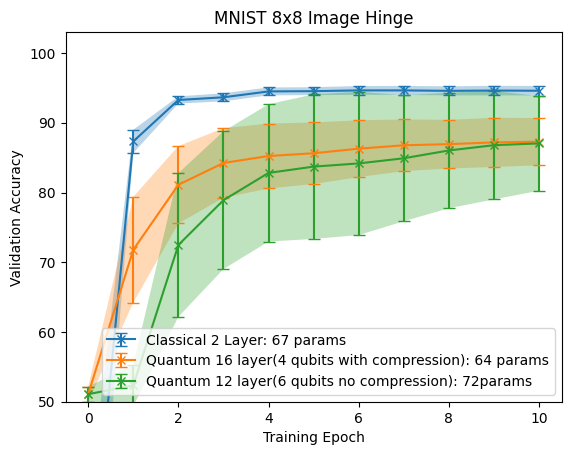

In [12]:
x = list(range(0, 11))
plt.title("MNIST 8x8 Image Hinge")
plt.ylabel("Validation Accuracy")
plt.xlabel("Training Epoch")
plt.ylim(50, 103)
plt.errorbar(x, cnn1_mean, cnn1_std, fmt='-x', capsize=4)
plt.errorbar(x, qnn2_mean, qnn2_std, fmt='-x', capsize=4)
plt.errorbar(x, qnn1_mean, qnn1_std, fmt='-x', capsize=4)
plt.legend(['Classical 2 Layer: 67 params', 'Quantum 16 layer(4 qubits with compression): 64 params', 'Quantum 12 layer(6 qubits no compression): 72params'])
plt.fill_between(x, cnn1_mean + cnn1_std, cnn1_mean - cnn1_std, alpha=0.3)
plt.fill_between(x, qnn2_mean + qnn2_std, qnn2_mean - qnn2_std, alpha=0.3)
plt.fill_between(x, qnn1_mean + qnn1_std, qnn1_mean - qnn1_std, alpha=0.3)


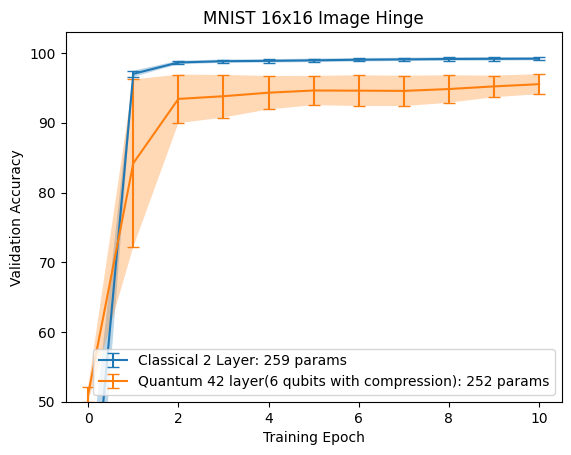

In [13]:
x = list(range(0, 11))
plt.title("MNIST 16x16 Image Hinge")
plt.ylabel("Validation Accuracy")
plt.xlabel("Training Epoch")
plt.ylim(50, 103)
plt.errorbar(x, cnn2_mean, cnn2_std, fmt='-', capsize=4)
plt.errorbar(x, qnn3_mean, qnn3_std, fmt='-', capsize=4)
plt.legend(['Classical 2 Layer: 259 params', 'Quantum 42 layer(6 qubits with compression): 252 params'])
plt.fill_between(x, cnn2_mean + cnn2_std, cnn2_mean - cnn2_std, alpha=0.3)
plt.fill_between(x, qnn3_mean + qnn3_std, qnn3_mean - qnn3_std, alpha=0.3)

In [14]:
# 5.2 MSE Loss 结果展示
validation_dict = np.load('validation_mse.npy', allow_pickle=True).item()
qnn1_mean = np.average(validation_dict['qnn1'], axis=0) * 100
qnn1_std = np.std(validation_dict['qnn1'], axis=0) * 100
qnn2_mean = np.average(validation_dict['qnn2'], axis=0) * 100
qnn2_std = np.std(validation_dict['qnn2'], axis=0) * 100
qnn3_mean = np.average(validation_dict['qnn3'], axis=0) * 100
qnn3_std = np.std(validation_dict['qnn3'], axis=0) * 100
cnn1_mean = np.average(validation_dict['cnn1'], axis=0) * 100
cnn1_std = np.std(validation_dict['cnn1'], axis=0) * 100
cnn2_mean = np.average(validation_dict['cnn2'], axis=0) * 100
cnn2_std = np.std(validation_dict['cnn2'], axis=0) * 100

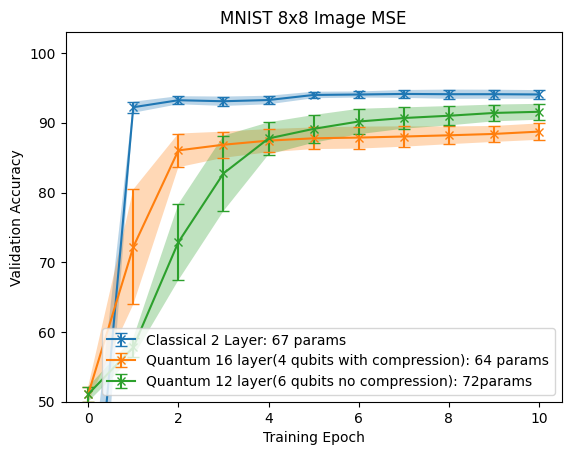

In [15]:
x = list(range(0, 11))
plt.title("MNIST 8x8 Image MSE")
plt.ylabel("Validation Accuracy")
plt.xlabel("Training Epoch")
plt.ylim(50, 103)
plt.errorbar(x, cnn1_mean, cnn1_std, fmt='-x', capsize=4)
plt.errorbar(x, qnn2_mean, qnn2_std, fmt='-x', capsize=4)
plt.errorbar(x, qnn1_mean, qnn1_std, fmt='-x', capsize=4)
plt.legend(['Classical 2 Layer: 67 params', 'Quantum 16 layer(4 qubits with compression): 64 params', 'Quantum 12 layer(6 qubits no compression): 72params'])
plt.fill_between(x, cnn1_mean + cnn1_std, cnn1_mean - cnn1_std, alpha=0.3)
plt.fill_between(x, qnn2_mean + qnn2_std, qnn2_mean - qnn2_std, alpha=0.3)
plt.fill_between(x, qnn1_mean + qnn1_std, qnn1_mean - qnn1_std, alpha=0.3)

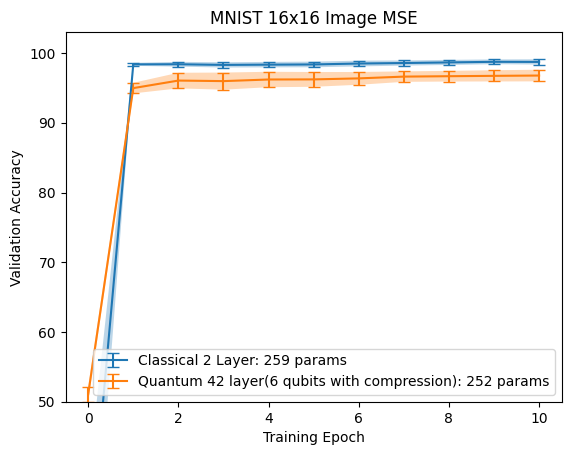

In [16]:
x = list(range(0, 11))
plt.title("MNIST 16x16 Image MSE")
plt.ylabel("Validation Accuracy")
plt.xlabel("Training Epoch")
plt.ylim(50, 103)
plt.errorbar(x, cnn2_mean, cnn2_std, fmt='-', capsize=4)
plt.errorbar(x, qnn3_mean, qnn3_std, fmt='-', capsize=4)
plt.legend(['Classical 2 Layer: 259 params', 'Quantum 42 layer(6 qubits with compression): 252 params'])
plt.fill_between(x, cnn2_mean + cnn2_std, cnn2_mean - cnn2_std, alpha=0.3)
plt.fill_between(x, qnn3_mean + qnn3_std, qnn3_mean - qnn3_std, alpha=0.3)